<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling Plan


- Model for Overall players
- Model for Foward position players
- Model for Midfielder postion players
- Model for Defense position plauyers
- Model for Goal Keepers

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

import model


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()
print("Row and column count:",df.shape)

Row and column count: (142079, 111)


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


## Removing outliers

In [4]:
cols = ['overall','potential'] 
def handle_outliers(df, cols, k):
    """this will eliminate most outliers, use a 1.5 k value if unsure because it is the most common, make sure to define cols value as the features
    you want the outliers to be handled. this should be done before running the function and outiside of it"""

    
    # Create placeholder dictionary for each columns bounds
    bounds_dict = {}
   
    for col in cols:
        # get necessary iqr values
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr

        #store values in a dictionary referencable by the column name
        #and specific bound
        bounds_dict[col] = {}
        bounds_dict[col]['upper_bound'] = upper_bound
        bounds_dict[col]['lower_bound'] = lower_bound

    for col in cols:
        #retrieve bounds
        col_upper_bound = bounds_dict[col]['upper_bound']
        col_lower_bound = bounds_dict[col]['lower_bound']

        #remove rows with an outlier in that column
    df = df[(df[col] < col_upper_bound) & (df[col] > col_lower_bound)]
        
    return df

df = handle_outliers(df,cols,1.5)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data for Modeling

In [5]:
train, validate, test = prepare.split(df)

Train: 58213 rows, 83 cols
Validate: 26055 rows, 83 cols
Test: 13946 rows, 83 cols


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Overall Players

## Plan
- Use key features to create a good predictive model
- Use a minimum of 3 models
- Pick the best performing model
- Run model on test data

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Relationship to Wage_euro Plot

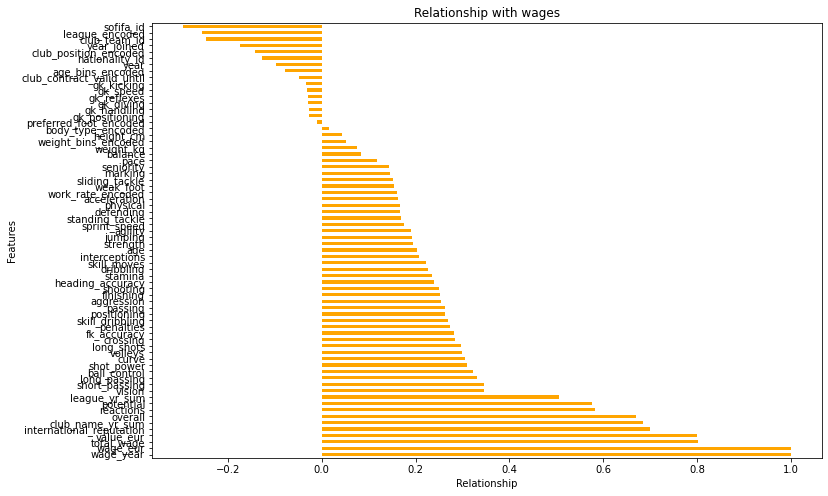

In [6]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [7]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(15)

                          wage_eur
wage_year                 1.000000
wage_eur                  1.000000
total_wage                0.801017
value_eur                 0.799072
international_reputation  0.699798
club_name_yr_sum          0.683929
overall                   0.670422
reactions                 0.582250
potential                 0.576212
league_yr_sum             0.506001
vision                    0.346656
short_passing             0.345914
long_passing              0.330425
ball_control              0.321539
shot_power                0.309107

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- international_reputation
- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



In [8]:
# identifying mvp columns
mvp = ['international_reputation','overall','reactions']

In [9]:
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

# RMSE

In [12]:
target = 'wage_eur'
#create baseline
metric_df, rmse_mean_train, rmse_mean_validate, rmse_median_train, rmse_median_validate, r2_baseline = model.create_baseline(y_train, y_validate, target)
#Linear Regression model
rmse_lm_train, rmse_lm_validate, r2_lm_value = model.create_model(LinearRegression(normalize = True), X_train,\
                                                                  X_validate, y_train, y_validate, 'wage_eur')
#Lasso + Lars model
rmse_lars_train, rmse_lars_validate, r2_lars_value = model.create_model(LassoLars(alpha = 1.0), X_train,\
                                                            X_validate, y_train, y_validate, 'wage_eur')
#Tweedie Regressor model
rmse_glm_train, rmse_glm_validate, r2_glm_value = model.create_model(TweedieRegressor(power = 1, alpha = 0.00),\
                                                            X_train, X_validate, y_train, y_validate, 'wage_eur')
print(metric_df)


RMSE Train: $14559.97
RMSE Validate: $13954.53
R²: 0.492
RMSE Train: $14562.73
RMSE Validate: $13907.08
R²: 0.496
RMSE Train: $12059.77
RMSE Validate: $11956.91
R²: 0.627
           model           rmse_train        rmse_validate  \
0  Mean Baseline             23481.13             19935.79   

             r^2_value  
0                -0.04  


In [13]:
y_test = pd.DataFrame(y_test)

y_test

                  wage_eur
4                115000.00
5                130000.00
6                160000.00
7                155000.00
9                100000.00
...                    ...
98696               500.00
98697               500.00
98698               500.00
98699               500.00
98700               500.00

[13946 rows x 1 columns]

In [26]:
model.create_model(LinearRegression(normalize = True), X_train,X_validate, y_train, y_validate, 'wage_eur')



RMSE Train: $14559.97
RMSE Validate: $13954.53
R²: 0.492


(None, None, None)

In [15]:
LassoLars = model.create_model(LassoLars(alpha = 1.0), X_train,X_validate, y_train, y_validate, 'wage_eur')

RMSE Train: $14562.73
RMSE Validate: $13907.08
R²: 0.496


In [16]:
TweedieRegressor = model.create_model(TweedieRegressor(power = 1, alpha = 0.00),X_train, X_validate, y_train, y_validate, 'wage_eur')

RMSE Train: $12059.77
RMSE Validate: $11956.91
R²: 0.627


# Evaluating Models

In [17]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train_scaled)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

NameError: name 'X_train_scaled' is not defined

In [ ]:
df = pd.DataFrame(train[['potential', 'reactions', 'vision', 'short_passing','long_passing',
       'ball_control','wage_eur','yhat']])
df.head()

In [ ]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

In [ ]:
baseline

In [ ]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

In [ ]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

In [ ]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

In [ ]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

In [ ]:
# sklearn.metrics.explained_variance_score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(df.wage_eur, df.yhat)
print('Explained Variance = ', round(evs,3))

In [ ]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.wage_eur, df.yhat)

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(df.potential)
est = sm.OLS(df.wage_eur, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

def regression_errors(actual, predicted):
    return pd.Series({
                        'SSE': sse(actual, predicted),
                        'ESS': ess(actual, predicted),
                        'TSS': tss(actual),
                        'MSE': mse(actual, predicted),
                        'RMSE': rmse(actual, predicted),
                        })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
             'SSE': sse(actual, predicted),
             'MSE': mse(actual, predicted),
             'RMSE': rmse(actual, predicted),
            }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [ ]:
actual = y_train.wage_eur
predicted = df.yhat
residuals = actual - predicted

In [ ]:
def actual_vs_predicted():
    # plot to visualize actual vs predicted. 
    plt.figure(figsize=(16,8))
    plt.hist(y_validate.wage_eur, color='blue', alpha=.5, label="Actual Final wage_eur")
    plt.hist(y_validate.wage_eur_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
    plt.hist(y_validate.wage_eur_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
    plt.hist(y_validate.wage_eur_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
    plt.xlabel("Final wage(eur)")
    plt.ylabel("predicted wage_eur")
    plt.title("Comparing the Distribution of Actual wage_eur to Distributions of Predicted wage_eur for the Top Models")
    plt.legend()
    plt.show()
actual_vs_predicted()

In [ ]:
y_train

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLM (tweedie)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Poly', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)}, ignore_index=True)

In [ ]:
metric_df  

In [ ]:
sdc

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LASSO'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_Poly'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_test}
""")



#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
sns.scatterplot(data = y_test)